Example usage of utilizing intermediate and last layer representations of a ResNet model on CIFAR-10 dataset.

Our work makes three main claims: 

1. Intermediate representations transfer to OOD data better than last layer representations when the model is trained on a small set of OOD data, and 
2. when the model is trained on ID data. 
3. This is because the intermediate representations discern between ID and OOD data less than the last layer representations. Intuitively, we can think of the intermediate representations as a more general feature extractor, while the last layer representations are more specific to the task at hand.

This notebook demonstrates these claims. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
''' Clone the repository for the CIFAR-10 dataset and download the weights'''
!mkdir dep_repos
!cd dep_repos && git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git
!cd dep_repos/PyTorch_CIFAR10 && python train.py --download_weights 1

mkdir: cannot create directory ‘dep_repos’: File exists


fatal: destination path 'PyTorch_CIFAR10' already exists and is not an empty directory.
100%|██████████████████████████████████████| 979M/979M [00:38<00:00, 25.2MMiB/s]
Download successful. Unzipping file...
Unzip file successful!


In [3]:
''' Download CIFAR-10C (takes few minutes) from 'Benchmarking Neural Network Robustness to Common Corruptions and               Perturbations' by Dan Hendrycks, Thomas Dietterich (https://github.com/hendrycks/robustness)
    Also, download CIFAR-10 dataset (6 train files and 1 test file) 
'''

from intermediate_gen.utils import download_cifar10, download_cifar10c

download_cifar10c()
download_cifar10()

CIFAR-10C dataset is downloaded and extracted to ./data/CIFAR-10C
CIFAR-10 dataset is downloaded and extracted to ./data/CIFAR-10


In [4]:
from intermediate_gen.datasets import CIFARC_TYPES, CIFARDataset
import torchvision
import torch 

cifar10_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(( 0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

print('Loading CIFAR-10 train and test datasets')
cifar10_train_dataset = CIFARDataset(root='./data/CIFAR-10/cifar-10-batches-py', transform=cifar10_transform, cifar_type=None, train=True)

cifar10_test_dataset = CIFARDataset(root='./data/CIFAR-10/cifar-10-batches-py', transform=cifar10_transform, cifar_type=None, train=False)

# load up cifar10-c datasets
cifar10c_datasets = {}
for cifar_type in CIFARC_TYPES:
    print(f'Loading CIFAR-10C dataset for type: {cifar_type}')
    cifar10c_datasets[cifar_type] = CIFARDataset(root='./data/CIFAR-10C/CIFAR-10-C', transform=cifar10_transform, cifar_type=cifar_type, train=False)


Loading CIFAR-10 train and test datasets
Loading CIFAR-10C dataset for type: brightness
Loading CIFAR-10C dataset for type: contrast
Loading CIFAR-10C dataset for type: defocus_blur
Loading CIFAR-10C dataset for type: elastic_transform
Loading CIFAR-10C dataset for type: fog
Loading CIFAR-10C dataset for type: frost
Loading CIFAR-10C dataset for type: gaussian_blur
Loading CIFAR-10C dataset for type: gaussian_noise
Loading CIFAR-10C dataset for type: glass_blur
Loading CIFAR-10C dataset for type: impulse_noise
Loading CIFAR-10C dataset for type: jpeg_compression
Loading CIFAR-10C dataset for type: motion_blur
Loading CIFAR-10C dataset for type: pixelate
Loading CIFAR-10C dataset for type: saturate
Loading CIFAR-10C dataset for type: shot_noise
Loading CIFAR-10C dataset for type: snow
Loading CIFAR-10C dataset for type: spatter
Loading CIFAR-10C dataset for type: speckle_noise
Loading CIFAR-10C dataset for type: zoom_blur


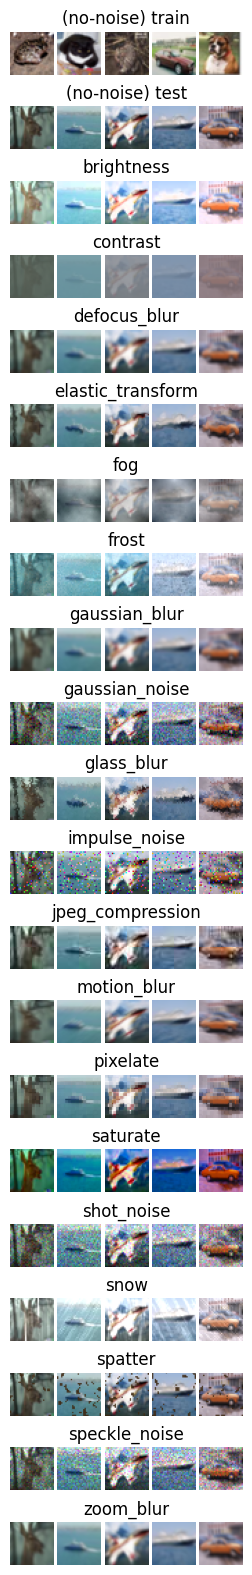

In [5]:
# Visualize a few samples. 
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=0)
idxs_take = rng.choice(len(cifar10_test_dataset), 5, replace=False)
n_samples_show = 5

showable_datasets = {
    '(no-noise) train': cifar10_train_dataset,
    '(no-noise) test': cifar10_test_dataset,
    **cifar10c_datasets
}
fig, axs = plt.subplots(len(showable_datasets), n_samples_show, figsize=(3, 20))

for i, (dataset_name, dataset) in enumerate(showable_datasets.items()):
    for j in range(n_samples_show):
        idx = idxs_take[j]
        sample, label = dataset[idx]
        sample = sample.permute(1, 2, 0)
        # unnormalize
        sample = (sample * torch.tensor((0.2023, 0.1994, 0.2010)) + torch.tensor((0.4914, 0.4822, 0.4465))).clamp(0, 1)
        axs[i, j].imshow(sample)

        axs[i, j].axis('off')
        if j == n_samples_show // 2:
            axs[i, j].set_title(f'{dataset_name}')
# spacing
plt.subplots_adjust(hspace=0.5, wspace=0.1)


In [6]:
''' The main piece of code for probing the model throughout the notebook '''

import torch
import torch.nn.functional as F

class LinearProbeModel(torch.nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        lr=0.0001,
        reg_type="l2",
        reg_weight=0.0,
        sgd_momentum=0.0,
        optimizer="SGD",
    ):
        super(LinearProbeModel, self).__init__()
        self.fc = torch.nn.Linear(input_size, output_size)
        self.lr = lr
        self.reg_type = reg_type
        self.reg_weight = reg_weight
        self.sgd_momentum = sgd_momentum

        # make an optimizer
        if optimizer == "SGD":
            self.optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=sgd_momentum)
        elif optimizer == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        return self.fc(x)

    def step_loss(self, x, y):
        ''' 
            x: representation from the backbone at the layer of interest (batch_size, feature_size)
            y: labels (batch_size)
        '''
        # get the output
        out = self.forward(x)
        # also get trainig accuracy
        accuracy = (torch.argmax(out, dim=1) == y).float().mean()
        # get the loss
        loss = F.cross_entropy(out, y)
        # add regularization
        if self.reg_type == "l2":
            loss += self.reg_weight * torch.norm(self.fc.weight, p=2)
        elif self.reg_type == "l1":
            loss += self.reg_weight * torch.norm(self.fc.weight, p=1)
        # zero the grads
        self.optimizer.zero_grad()
        # backprop
        loss.backward()
        # step the optimizer
        # see if the params change
        self.optimizer.step()
        return {
            "loss": loss.item(),
            "accuracy": accuracy.item(),
            "preds": out
        }


In [7]:
from examples.dep_repos.PyTorch_CIFAR10.cifar10_models.resnet import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=True)
model.eval()

# we freeze the model here to ensure that the backbone is not trained
for param in model.parameters():
    param.requires_grad = False

In [8]:
''' Zero-shot results: training classifiers on intermediate representations using the original CIFAR-10 dataset '''

def get_repr_dim_at_layer(model, layer_idx, init_input):
    ''' Get the shape of the representation at the layer of interest '''
    model.eval()
    
    for idx, layer in enumerate(model.children()):
        init_input = layer(init_input)
        if idx == layer_idx:
            return init_input.numel()
    raise ValueError(f'Layer index {layer_idx} is out of bounds for the model')

layers_to_probe = range(2,9)
assert all([0 <= layer_idx < len(list(model.children())) for layer_idx in layers_to_probe]) and max(layers_to_probe) == len(list(model.children())) - 2, f'Invalid layer indices: {layers_to_probe}; model has {len(list(model.children()))} layers'

lin_probes = {}

model.to(device)

for layer_idx in layers_to_probe:
    sample_input = torch.randn((1, 3, 32, 32), device=device)
    repr_dim = get_repr_dim_at_layer(model, layer_idx, sample_input)
    print(f'Layer {layer_idx} representation dimension: {repr_dim}')

    lin_probe_at_idx = LinearProbeModel(input_size=repr_dim, output_size=10, lr=1e-3, reg_type="l2", reg_weight=1e-3, sgd_momentum=0.0, optimizer="adam")

    lin_probes[layer_idx] = lin_probe_at_idx

# we initialize the probe on the last layer with the same weights as the last layer of the backbone
lin_probes[8].fc.weight.data = model.fc.weight.data.clone()
lin_probes[8].fc.bias.data = model.fc.bias.data.clone()

for _, lin_probe in lin_probes.items():
    lin_probe.to(device)

Layer 2 representation dimension: 65536
Layer 3 representation dimension: 16384
Layer 4 representation dimension: 16384
Layer 5 representation dimension: 8192
Layer 6 representation dimension: 4096
Layer 7 representation dimension: 2048
Layer 8 representation dimension: 512


In [9]:
# Train the model and track the performance on the distribution shifts through time
@torch.no_grad()
def evaluate_model_on_dataset(model, dataloader, lin_probes):
    ''' Evaluate the model on the dataset and return the loss and accuracy for each layer.
        As a special case, we also evaluate the last layer of the backbone (referenced as 'll' in the results dict)
    '''
    model.eval()
    results = {}
    for layer_idx, lin_probe in {**lin_probes, 'last-layer': None}.items():
        results[layer_idx] = {
            'loss': 0.0,
            'accuracy': 0.0,
            'preds': []
        }

    def get_stats_for_output(out, label):
        loss = F.cross_entropy(out, label, reduction='sum')
        accuracy = (torch.argmax(out, dim=1) == label).float().sum()
        return loss, accuracy
    
    for _, (sample, label) in enumerate(dataloader):
        sample, label = sample.to(device), label.to(device)
        x = sample
        for layer_idx, layer in enumerate(model.children()):
            # ResNet's .forward() reshapes the input at the 9th layer - 
            # since we aren't using their .forward() method,
            # we need to reshape it ourselves
            x = layer(x if layer_idx <= 8 else x.view(x.size(0), -1))
            if layer_idx in lin_probes:
                x_detached_flat = x.detach().view(x.size(0), -1)

                # get the prediction
                lin_probe = lin_probes[layer_idx]
                out = lin_probe(x_detached_flat)
                loss, accuracy = get_stats_for_output(out, label)
                results[layer_idx]['loss'] += loss.item()
                results[layer_idx]['accuracy'] +=  accuracy.item()
        # also pass the last layer of the backbone
        loss_last_layer, accuracy_last_layer = get_stats_for_output(x, label)
        results['last-layer']['loss'] += loss_last_layer.item()
        results['last-layer']['accuracy'] += accuracy_last_layer.item()
        
    for layer_idx, _ in results.items():
        results[layer_idx]['loss'] = np.sum(results[layer_idx]['loss']) / len(dataloader.dataset)
        results[layer_idx]['accuracy'] = np.sum(results[layer_idx]['accuracy']) / len(dataloader.dataset)
    return results

# Let's evaluate the model first - make the train and test dataloaders
batch_size=256
train_loader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=batch_size, shuffle=False)

ood_loaders = {cifar_type: torch.utils.data.DataLoader(cifar10c_datasets[cifar_type], batch_size=batch_size, shuffle=False) for cifar_type in CIFARC_TYPES}

all_test_loaders = {
    'test': test_loader,
    **ood_loaders
}

In [10]:
# Split the OOD datasets into validation and test sets
valid_ood_datasets = {}
test_ood_datasets = {}
frac_valid = 0.1 # around 1000 samples
for cifar_type, cifar_dataset in cifar10c_datasets.items():
    rng=np.random.default_rng(seed=0)
    n_valid = int(frac_valid * len(cifar_dataset))
    random_idxs = rng.permutation(len(cifar_dataset))
    valid_idxs = random_idxs[:n_valid]
    test_idxs = random_idxs[n_valid:]

    valid_ood_datasets[cifar_type] = torch.utils.data.Subset(cifar_dataset, valid_idxs)
    test_ood_datasets[cifar_type] = torch.utils.data.Subset(cifar_dataset, test_idxs)

# make the loaders
train_loader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size=batch_size, shuffle=True)
valid_loaders = {cifar_type: torch.utils.data.DataLoader(valid_ood_datasets[cifar_type], batch_size=batch_size, shuffle=False) for cifar_type in CIFARC_TYPES}
test_loaders = {cifar_type: torch.utils.data.DataLoader(test_ood_datasets[cifar_type], batch_size=batch_size, shuffle=False) for cifar_type in CIFARC_TYPES}

In [11]:
# Now, actually train the model using the original training data. We could pre-cache the representations for the layers of interest, but because the training is fast, we can do it on-the-fly.
# It takes around 5 minutes in total on a GPU. 

from tqdm import tqdm

num_epochs = 50

valid_perfs_per_shift_per_layer = {}
best_probe_per_shift = {}

for epoch in tqdm(range(num_epochs)):
    for _, (sample, label) in enumerate(train_loader):
        sample, label = sample.to(device), label.to(device)
        x = sample
        for layer_idx, layer in enumerate(model.children()):
            x = layer(x if layer_idx <= 8 else x.view(x.size(0), -1))
            if layer_idx in lin_probes:
                x_detached_flat = x.detach().view(x.size(0), -1)

                # get the prediction
                lin_probe = lin_probes[layer_idx]
                lin_probe.step_loss(x_detached_flat, label)
    # evaluation on validation set. 
    for cifar_type, loader in valid_loaders.items():
        valid_results = evaluate_model_on_dataset(model, loader, lin_probes)

        for layer_name, layer_results in valid_results.items():
            set_layer_pair = (cifar_type, layer_name)

            if set_layer_pair not in valid_perfs_per_shift_per_layer:
                valid_perfs_per_shift_per_layer[set_layer_pair] = {
                    'accuracy': -np.inf
                }
            if layer_results['accuracy'] > valid_perfs_per_shift_per_layer[set_layer_pair]['accuracy']:
                valid_perfs_per_shift_per_layer[set_layer_pair] = {
                    'accuracy': layer_results['accuracy'],
                    'epoch': epoch
                }
                if layer_name != 'last-layer':
                    best_probe_per_shift[set_layer_pair] = {k: v.cpu().clone() for k, v in lin_probes[layer_name].state_dict().items()}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [06:30<00:00,  7.81s/it]


In [12]:
# Finally, do evaluation: use the previously stored best probes to evaluate the model on the test set
results_all_shifts = {}
for cifar_type, loader in all_test_loaders.items():
    if cifar_type == 'test':
        continue
    print(f'Evaluating on {cifar_type}')
    probes_for_type = {layer_name: LinearProbeModel(input_size=lin_probes[layer_name].fc.in_features, output_size=10) for layer_name in layers_to_probe if layer_name != 'last-layer'}
    # init
    for layer_name in probes_for_type:
        cifar_type_layer = (cifar_type, layer_name)
        probes_for_type[layer_name].load_state_dict(best_probe_per_shift[cifar_type_layer])
        probes_for_type[layer_name].to(device)
        probes_for_type[layer_name].eval()

    results = evaluate_model_on_dataset(model, loader, probes_for_type)
    results_all_shifts[cifar_type] = results

Evaluating on brightness
Evaluating on contrast
Evaluating on defocus_blur
Evaluating on elastic_transform
Evaluating on fog
Evaluating on frost
Evaluating on gaussian_blur
Evaluating on gaussian_noise
Evaluating on glass_blur
Evaluating on impulse_noise
Evaluating on jpeg_compression
Evaluating on motion_blur
Evaluating on pixelate
Evaluating on saturate
Evaluating on shot_noise
Evaluating on snow
Evaluating on spatter
Evaluating on speckle_noise
Evaluating on zoom_blur


In [13]:
import pandas as pd

df_valid_perfs = pd.DataFrame(valid_perfs_per_shift_per_layer).T.reset_index()
df_valid_perfs.columns = ['shift', 'layer', 'accuracy', 'epoch']
# make sure correct types
df_valid_perfs['accuracy'] = df_valid_perfs['accuracy'].astype(float)
df_valid_perfs['epoch'] = df_valid_perfs['epoch'].astype(int)
df_valid_perfs['shift'] = df_valid_perfs['shift'].astype(str)

/tmp/ipykernel_142707/2540324494.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_shift = df_valid_perfs[df_valid_perfs['shift'] == dist_shift][df_valid_perfs['layer'] != 'last-layer'][df_valid_perfs['layer'] != 8]
/tmp/ipykernel_142707/2540324494.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_shift = df_valid_perfs[df_valid_perfs['shift'] == dist_shift][df_valid_perfs['layer'] != 'last-layer'][df_valid_perfs['layer'] != 8]
/tmp/ipykernel_142707/2540324494.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_shift = df_valid_perfs[df_valid_perfs['shift'] == dist_shift][df_valid_perfs['layer'] != 'last-layer'][df_valid_perfs['layer'] != 8]
/tmp/ipykernel_142707/2540324494.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_shift = df_valid_perfs[df_valid_perfs['shift'] == dist_shift][df_valid_perfs['layer'] != 'last-layer'][df_valid_perfs

best layer for brightness: 6
best layer for contrast: 4
best layer for defocus_blur: 7
best layer for elastic_transform: 7
best layer for fog: 7
best layer for frost: 7
best layer for gaussian_blur: 7
best layer for gaussian_noise: 2
best layer for glass_blur: 6
best layer for impulse_noise: 2
best layer for jpeg_compression: 7
best layer for motion_blur: 7
best layer for pixelate: 6
best layer for saturate: 5
best layer for shot_noise: 2
best layer for snow: 7
best layer for spatter: 5
best layer for speckle_noise: 7
best layer for zoom_blur: 7


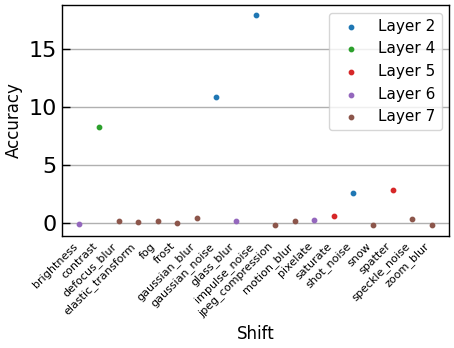

In [15]:
# Display the results - since we hadn't trained the probes, the results aren't expected to be good
import scienceplots
plt.style.use(['science', 'notebook'])
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['xtick.minor.width'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['ytick.minor.width'] = 0
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'axes.titlesize': 12})
plt.rcParams.update({'legend.fontsize': 12})

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
colors=plt.cm.tab10.colors
layers_to_probe = list(lin_probes.keys()) + ['last-layer']

# fox axs[3], show the rel difference to the best layer - do model selection based on the validation accuracy
diffs_to_last_layer = []
disp_labels = set()
for shift_idx, dist_shift in enumerate(CIFARC_TYPES):
    df_shift = df_valid_perfs[df_valid_perfs['shift'] == dist_shift][df_valid_perfs['layer'] != 'last-layer'][df_valid_perfs['layer'] != 8]
    best_layer = df_shift.loc[df_shift['accuracy'].idxmax()]['layer']

    print(f'best layer for {dist_shift}: {best_layer}')
    # plot the scatter
    best_layer_test_perf = results_all_shifts[dist_shift][best_layer]['accuracy']

    last_layer_test_perf = max(results_all_shifts[dist_shift]['last-layer']['accuracy'], results_all_shifts[dist_shift][8]['accuracy'])

    rel_perf = best_layer_test_perf - last_layer_test_perf

    ax.scatter(dist_shift, rel_perf * 100, color=colors[best_layer - min(lin_probes.keys())], zorder=5, s=10, label=f'Layer {best_layer}' if best_layer not in disp_labels else None)
    disp_labels.add(best_layer)
# sort labels
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split(' ')[1])))
ax.legend(handles, labels, frameon=True, fontsize=11)

ax.set_xticks(CIFARC_TYPES)
ax.set_xticklabels(CIFARC_TYPES, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Shift')
ax.grid(axis='y')

# savefig png
plt.show()
